In [17]:
import numpy as np
import os
import lightning as pl
from matplotlib import pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import random

# Parameters:

In [18]:
sns.set_style("white")

test_ratio = 0.0
num_data = 20
HIDDEN_UNITS = 100


# Dataset:

In [19]:
def func(x):
    return np.power(x, 3) + 100*np.sin(x) + np.random.normal(0, 50, x.shape)

# for training:
data_x = np.random.uniform(-4, 4, size=num_data)
data_y = np.zeros(num_data)

# for plotting:
num_data_true = 1000
data_x_true = np.linspace(-6, 6, num_data_true)
data_y_true = np.zeros(num_data_true)

In [20]:
for i in range(num_data):
    if (data_x[i] < 0): 
        data_y[i] = func(data_x[i]) + np.random.normal(0, 3) # x<0, sigma=3 (less noisy measurement)
    else: 
        data_y[i] = func(data_x[i]) + np.random.normal(0, 9) # x>=0, sigma=9 (more noisy measurement)
        
for i in range(num_data_true):
    data_y_true[i] = func(data_x_true[i])

In [21]:
num_train_data = int(num_data * (1 - test_ratio))
num_test_data  = num_data - num_train_data
print("num_train_data: ", num_train_data)

data_x = np.reshape(data_x, [num_data, 1])
data_y = np.reshape(data_y, [num_data, 1])
data_y_true = np.reshape(data_y_true, [num_data_true, 1])
data_x_true = np.reshape(data_x_true, [num_data_true, 1])

train_x = data_x[:num_train_data, :]
train_y = data_y[:num_train_data, :]
test_x  = data_x[num_train_data:, :]
test_y  = data_y[num_train_data:, :]

num_train_data:  20


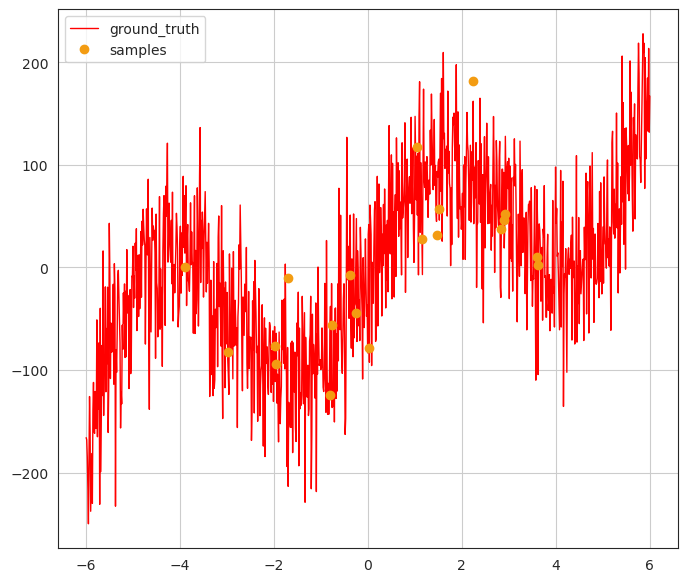

In [22]:
plt.figure(figsize=[8, 7])

plt.plot(data_x_true, data_y_true, 'r', linewidth=1, label='ground_truth')
plt.plot(data_x, data_y, '.', markersize=12, color='#F39C12', label='samples')

plt.legend(loc='best')
plt.grid()
plt.show()

# Model:

In [23]:
pi = torch.tensor(np.pi)

def gaussian_nll(mean, variance, y):
    return torch.mean((torch.log(variance) * 0.5) + ((0.5 * (y - mean).square()) / variance)) + torch.log(2 * pi)

# 1 hidden layer, ReLU activation 
class MultiLayerPerceptron(nn.Module):
    
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        self.fc1 = nn.Linear(self.input_dim, HIDDEN_UNITS)
        self.fc2 = nn.Linear(HIDDEN_UNITS, self.output_dim)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x
    
# 1 hidden layer, ReLU activation, Gaussian output (mean, variance)
class GaussianMultiLayerPerceptron(MultiLayerPerceptron):
    
    def __init__(self, input_dim, output_dim=2):
        super().__init__(input_dim, output_dim)
 
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        mean, variance = torch.split(x, 1, dim=1)
        variance = F.softplus(variance) + 1e-6 # Positive constraint
        return mean, variance

In [24]:
tensor_x = torch.Tensor(train_x) # transform to torch tensor
tensor_y = torch.Tensor(train_y)

toy_dataset = TensorDataset(tensor_x, tensor_y) # create your datset
dataloader = DataLoader(toy_dataset, num_workers=1, batch_size=1, shuffle=True) # create your dataloader

# Training setup (Pytorch Lightning)

In [25]:
data_range = 1 # adjustment on epsilon according to range along a dimension
EPSILON = 0.01
GAUSSIAN_LR = 0.1

# FGSM attack code / adversarial attack input generation
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon*sign_data_grad
    return perturbed_image

class MLP(pl.LightningModule):
  
  def __init__(self):
    super().__init__()
    self.model = MultiLayerPerceptron(1, 1)
    self.loss = nn.MSELoss()
    
  def forward(self, x):
    return self.model(x)
  
  def training_step(self, batch, batch_idx):
    x, y = batch
    x = x.view(x.size(0), -1)
    y_hat = self.model(x)
    loss = self.loss(y_hat, y)
    self.log('train_loss', loss)
    return loss
  
  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=1e-2)
    return optimizer

class GaussianMLP(pl.LightningModule):
  
  def __init__(self):
    super().__init__()
    self.model = GaussianMultiLayerPerceptron(1, 2)
    self.loss = gaussian_nll
    
  def forward(self, x):
    return self.model(x)
  
  def training_step(self, batch, batch_idx):
    x, y = batch
    x.requires_grad = True
    x = x.view(x.size(0), -1)
    mean, var = self.model(x)
    loss_for_adv = F.gaussian_nll_loss(mean, y, var)
    grad = torch.autograd.grad(loss_for_adv, x, retain_graph=False)[0]
    x = x.detach()
    y = y.detach()
    mean = mean.detach()
    var = var.detach()
    loss_for_adv.detach_()
    perturbed_data = fgsm_attack(x, EPSILON * data_range, grad) # 8 is range of data
    mean_adv, var_adv = self.model(perturbed_data)
    loss = F.gaussian_nll_loss(mean, y, var) + F.gaussian_nll_loss(mean_adv, y, var_adv)
    self.log('train_loss', loss)
    torch.nn.utils.clip_grad_norm_(self.model.parameters(), 100)
    return loss
  
  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=GAUSSIAN_LR)
    return optimizer

## Training

In [26]:
mlp = GaussianMLP()
trainer = pl.Trainer(devices=1, accelerator="gpu", max_epochs=100)
trainer.fit(mlp, dataloader)

/home/anthosmakris/miniconda3/envs/predictive/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/anthosmakris/miniconda3/envs/predictive/lib/py ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name  | Type                         | Params | Mode 
---------------------------------------------------------------
0 | model | GaussianMultiLayerPerceptron | 402    | train
---------------------------------------------------------------
402       Trainable params
0         Non-trainable params
402       Total params
0.002     Total estimated model params size (MB)
/home/anthosmakris/miniconda3/envs/predictive/lib/python3.12/site-packages/lightning/pytor

Epoch 99: 100%|██████████| 20/20 [00:00<00:00, 57.38it/s, v_num=45]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 20/20 [00:00<00:00, 56.51it/s, v_num=45]


In [27]:
mlp.eval()
means = []
variances = []

for x in data_x_true:
    mean, var = mlp(torch.Tensor(x).unsqueeze(0))
    means.append(mean.item())
    variances.append(var.item())

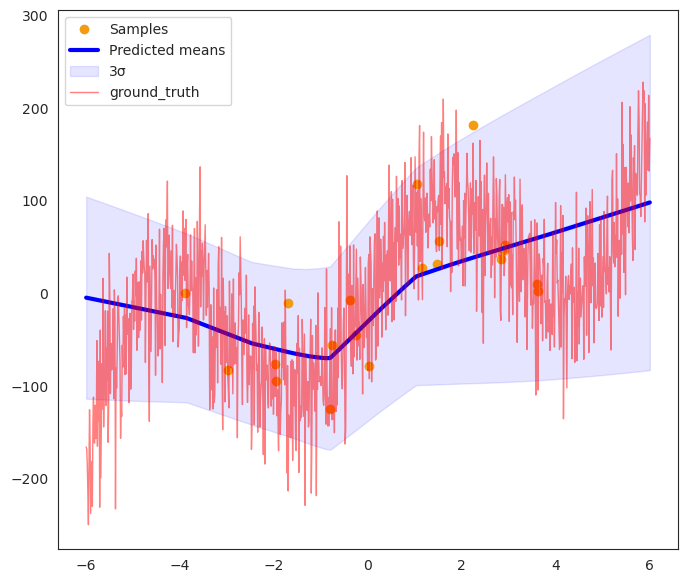

In [28]:
upper = [i + np.sqrt(k) * 3 for i, k in zip(means, variances)]
lower = [i - np.sqrt(k) * 3 for i, k in zip(means, variances)]

fig, ax = plt.subplots(1, 1, figsize=(8, 7))
# plt.axvline(x=0, linewidth=2)
plt.plot(data_x, data_y, 'o', markersize=6, color='#F39C12')
plt.plot(data_x_true, means, linewidth=2, color='b')
plt.fill_between(data_x_true.flatten(), upper, lower, color="blue", alpha=0.1)
plt.plot(data_x_true, data_y_true, 'r', linewidth=1, alpha=0.5)
plt.legend(['Samples', 'Predicted means' , '3σ', 'ground_truth'], loc = 'best')
plt.grid()
plt.show() 

# Ensemble:

In [29]:
models = []

for i in range(5):
    seed = random.randint(0, 9999)
    print(f"{i} seed: {seed}")
    pl.seed_everything(seed)
    mlp = GaussianMLP()
    trainer = pl.Trainer(devices=1, accelerator="gpu", max_epochs=50)
    dataloader = DataLoader(toy_dataset, num_workers=1, batch_size=1, shuffle=True)
    trainer.fit(mlp, dataloader)
    models.append(mlp)

Seed set to 2959
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name  | Type                         | Params | Mode 
---------------------------------------------------------------
0 | model | GaussianMultiLayerPerceptron | 402    | train
---------------------------------------------------------------
402       Trainable params
0         Non-trainable params
402       Total params
0.002     Total estimated model params size (MB)


0 seed: 2959
Epoch 49: 100%|██████████| 20/20 [00:00<00:00, 63.47it/s, v_num=46]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 20/20 [00:00<00:00, 62.57it/s, v_num=46]


Seed set to 5262


1 seed: 5262


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name  | Type                         | Params | Mode 
---------------------------------------------------------------
0 | model | GaussianMultiLayerPerceptron | 402    | train
---------------------------------------------------------------
402       Trainable params
0         Non-trainable params
402       Total params
0.002     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 20/20 [00:00<00:00, 60.88it/s, v_num=47]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 20/20 [00:00<00:00, 59.84it/s, v_num=47]


Seed set to 1166


2 seed: 1166


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name  | Type                         | Params | Mode 
---------------------------------------------------------------
0 | model | GaussianMultiLayerPerceptron | 402    | train
---------------------------------------------------------------
402       Trainable params
0         Non-trainable params
402       Total params
0.002     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 20/20 [00:00<00:00, 55.68it/s, v_num=48]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 20/20 [00:00<00:00, 54.93it/s, v_num=48]


Seed set to 913


3 seed: 913


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name  | Type                         | Params | Mode 
---------------------------------------------------------------
0 | model | GaussianMultiLayerPerceptron | 402    | train
---------------------------------------------------------------
402       Trainable params
0         Non-trainable params
402       Total params
0.002     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 20/20 [00:00<00:00, 56.70it/s, v_num=49]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 20/20 [00:00<00:00, 56.00it/s, v_num=49]


Seed set to 1549


4 seed: 1549


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name  | Type                         | Params | Mode 
---------------------------------------------------------------
0 | model | GaussianMultiLayerPerceptron | 402    | train
---------------------------------------------------------------
402       Trainable params
0         Non-trainable params
402       Total params
0.002     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 20/20 [00:00<00:00, 58.30it/s, v_num=50]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 20/20 [00:00<00:00, 57.20it/s, v_num=50]


In [30]:
means = []
variances = []

for model in models:
    model.eval()
    preds = []
    sigmas = []

    for x in data_x_true:
        mu, sigma = model(torch.Tensor(x).unsqueeze(0))
        preds.append(mu.item())
        sigmas.append(sigma.item())
    
    means.append(preds)
    variances.append(sigmas)
means = torch.tensor(means)
variances = torch.tensor(variances)

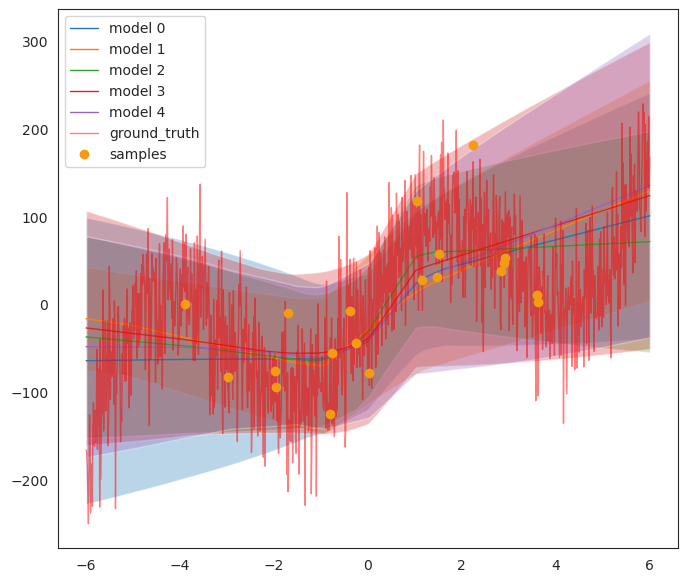

In [31]:
mean = means.mean(0)
variance = (variances +  means.pow(2)).mean(0) - mean.pow(2)

fig, ax = plt.subplots(1, 1, figsize=(8, 7))
for i, (mean, variance) in enumerate(zip(means, variances)):
    std = np.sqrt(variance.numpy()) * 3
    upper = [i + k for i, k in zip(mean.numpy(), std)]
    lower = [i - k for i, k in zip(mean.numpy(), std)]
    plt.fill_between(data_x_true.flatten(), upper, lower, alpha=0.3)
    plt.plot(data_x_true, mean, label=f'model {i}', linewidth=1)
plt.plot(data_x_true, data_y_true, 'r', linewidth=1, label='ground_truth', alpha=0.5)
plt.plot(data_x, data_y, '.', markersize=12, color='#F39C12', label='samples')
plt.legend(loc = 'best')
plt.grid()
plt.show()